# Barotropic kinetic energy fraction

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from dask.diagnostics import ProgressBar
import warnings
warnings.filterwarnings("ignore")

In [2]:
from yamlparser import YAMLParser, read_parameterized_runs, read_unparameterized_runs

In [3]:
yp = YAMLParser()

In [4]:
# read parameterized runs
exps_param = yp.read('/glade/u/home/noraloose/GL90paper/config_param.yaml')
%time exps_param = read_parameterized_runs(exps_param)

nw2_0.5deg_N15_KHTH800
nw2_0.5deg_N15_KHGL800_hbbl5
nw2_0.5deg_N15_KHTH800_vary
nw2_0.5deg_N15_KHGL800_vary_hbbl5
nw2_0.5deg_N15_EBT_KHTH800
nw2_0.5deg_N15_EBT_KHGL800_hbbl5
nw2_0.25deg_N15_KHTH300
nw2_0.25deg_N15_KHGL300_hbbl1
nw2_0.25deg_N15_KHGL300_hbbl5
nw2_0.25deg_N15_KHGL300_hbbl20
nw2_0.25deg_N15_KHGL300
nw2_0.25deg_N15_KHTH800
nw2_0.25deg_N15_KHGL800_hbbl5
nw2_0.25deg_N15_KHTH300_vary
nw2_0.25deg_N15_KHGL300_vary_hbbl5
nw2_0.25deg_N15_EBT_KHTH300
nw2_0.25deg_N15_EBT_KHGL300_hbbl5
nw2_0.125deg_N15_KHTH100
nw2_0.125deg_N15_KHGL100_hbbl5
nw2_0.125deg_N15_KHTH800
nw2_0.125deg_N15_KHGL800_hbbl5
nw2_0.125deg_N15_KHTH100_vary
nw2_0.125deg_N15_KHGL100_vary_hbbl5
nw2_0.125deg_N15_EBT_KHTH100
nw2_0.125deg_N15_EBT_KHGL100_hbbl5
CPU times: user 11.2 s, sys: 1.46 s, total: 12.6 s
Wall time: 1min 30s


In [5]:
# read unparameterized runs
exps_unparam = yp.read('/glade/u/home/noraloose/GL90paper/config_unparam.yaml')
%time exps_unparam = read_unparameterized_runs(exps_unparam)

CPU times: user 1.66 s, sys: 760 ms, total: 2.42 s
Wall time: 12 s


## Compute barotropic vs baroclinic contributions

barotropic velocities:
$$
    u_{bt} = \frac{\sum_n h_n u_n}{\sum_n h_n}, \qquad 
    v_{bt} = \frac{\sum_n h_n v_n}{\sum_n h_n}
$$
baroclinic velocities:
$$
    u_{n,bc} = u_n - u_{bt}, \qquad 
    v_{n,bc} = v_n - v_{bt}
$$

In [6]:
for exp, v in exps_param.items():
        ds = v['ds']
        grid = v['grid']
        st = v['st']
        h_u = grid.interp(ds['h'], 'X')
        h_v = grid.interp(ds['h'], 'Y', boundary='fill')

        ds['hKE'] = ds['h'] * ds['KE']

        ds['u_bt'] = ((ds['uh'] / st.dyCu).sum(dim='zl')/ h_u.sum(dim='zl')).chunk({'yh': len(st.yh), 'xq': len(st.xq)})
        ds['v_bt'] = ((ds['vh'] / st.dxCv).sum(dim='zl') / h_v.sum(dim='zl')).chunk({'yq': len(st.yq), 'xh': len(st.xh)})

barotropic KE:
$$
    KE_{bt} = \frac{1}{2} \left(\sum_n h_n\right) (u_{bt}^2 + v_{bt}^2)
$$
baroclinic KE:
$$
    KE_{bc} = \frac{1}{2} \sum_n h_n (u_{n,bc}^2 + v_{n,bc}^2)  = KE - KE_{bt}
$$

Ratio: 
$$
    \frac{KE_{bt}}{KE} = \frac{KE_{bt}}{KE_{bt}+KE_{bc}}
$$

In [7]:
for exp, v in exps_param.items():
        ds = v['ds']
        grid = v['grid']
        
        
        ds['KE_bt'] = 0.5 * ds['h'].sum(dim='zl') * (
            grid.interp(ds['u_bt']**2, 'X')
            + grid.interp(ds['v_bt']**2, 'Y', boundary='fill')
        )
        ds['baro_fraction'] = ds['KE_bt'] / ds['hKE'].sum(dim='zl')


## Compute time average

In [8]:
for exp, v in exps_param.items():
        ds = v['ds']
        dst = ds.mean(dim='time', keep_attrs=True)
        if 'dst' in v: # some experiments have pre-computed time averaged fields
            for field in v['dst'].data_vars:
                dst[field] = v['dst'][field]
        v['dst'] = dst


# BT vs BC plots

In [9]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'large',
         'axes.labelsize': 'large',
         'axes.titlesize':'large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large',
         'font.size': 14}
pylab.rcParams.update(params)

In [10]:
def BTBC_line(vlist0, vlist1, colorlist0, colorlist1, abc0, abc1, degree):
    
    fig, axs = plt.subplots(1, 2, figsize=(10, 6.5))
                     
    for ax, vlist, colorlist, abc in zip(axs, [vlist0, vlist1], [colorlist0, colorlist1], [abc0, abc1]):
        if len(vlist) > 0:
            for v, color in zip(vlist, colorlist):
                ds = v['ds']
                print('%s: %i; %g' %(v['label'], len(ds.time), ds.time[0].values))
                dst = v['dst']
                st = v['st']
                label = v['label']
                barotropic = dst['baro_fraction'].mean(dim='xh')
                barotropic.plot(ax=ax, y='yh', linewidth=3, label=label, color=color) 

            for exp, v in exps_unparam.items():
                if v['degree'] == 0.03125:
                    dst = v['dst']
                    st = v['st']
                    barotropic = dst['baro_fraction'].mean(dim='xh')

                    label = '1/32$^\circ$ no param'
                    barotropic.plot(ax=ax, y='yh', linewidth=3, color='gray', label=label, linestyle='solid') 

            ax.set_xlim(0, 1)
            ax.set_ylim(-70, 70)
            ax.set_yticks(ticks=np.arange(-60, 61, 20))
            ax.set_title('%s Barotropic fraction' %abc)
            ax.set_xlabel('')
            ax.grid(color='0.5')
            ax.set_xticks(ticks=[0, 0.25, 0.5, 0.75, 1]) 
            
            ax.set(
                yticklabels=[r'60$^\circ$S', r'40$^\circ$S', r'20$^\circ$S',  r'0$^\circ$',  r'20$^\circ$N', r'40$^\circ$N', r'60$^\circ$N'],
                ylabel='Latitude'
            )
            if ax == axs[0]:
                handles0, labels0 = ax.get_legend_handles_labels()
        else:
            ax.axis('off')
                    
    # make legend that combines lines from both plots
    if len(vlist0) > 0:
        handles1, labels1 = ax.get_legend_handles_labels()
        handles = handles0[:2] + handles1
        labels = labels0[:2] + labels1
        legend = ax.legend(handles, labels, bbox_to_anchor=(1.1,0.5), loc="center left", ncol=1, fontsize=16)
    else:
        legend = ax.legend(bbox_to_anchor=(1.1,0.5), loc="center left", ncol=1, fontsize=16)
        
    plt.subplots_adjust(wspace=0.5)  

    return fig



### 1/2 degree main text

In [11]:
vlist = [
    exps_param['nw2_0.5deg_N15_KHTH800'],
    exps_param['nw2_0.5deg_N15_KHGL800_hbbl5'],
]
for v in vlist:
    with ProgressBar():
        v['dst']['baro_fraction'].load()

[########################################] | 100% Completed |  1min  2.2s
[########################################] | 100% Completed |  1min 11.8s


$1/2^\circ$ GM 800: 400; 75002.5
$1/2^\circ$ GL 800: 400; 75002.5


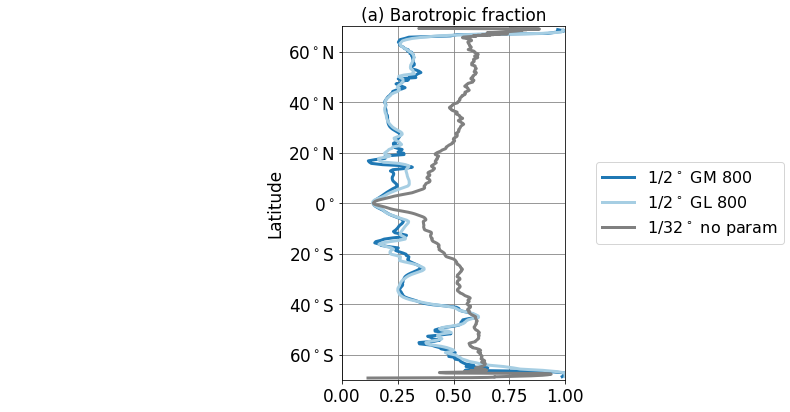

In [12]:
degree = 0.5
    
v = exps_param['nw2_0.5deg_N15_KHGL800_hbbl5']
v['label'] = r'$1/2^\circ$ GL 800'
v = exps_param['nw2_0.5deg_N15_KHTH800']
v['label'] = r'$1/2^\circ$ GM 800'

colorlist1 = ['#1f78b4', '#a6cee3']
vlist1 = [
    exps_param['nw2_0.5deg_N15_KHTH800'],
    exps_param['nw2_0.5deg_N15_KHGL800_hbbl5'],
]
abc1 = '(a)'

fig = BTBC_line([], vlist1, [], colorlist1, '', abc1, degree)
figname = '/glade/u/home/noraloose/GL90paper/figures/BTBC_0.5degree.png'
plt.savefig(figname, dpi=200, bbox_inches='tight', pad_inches=0)

### 1/2 degree appendix

In [13]:
vlist = [
    exps_param['nw2_0.5deg_N15_EBT_KHTH800'],
    exps_param['nw2_0.5deg_N15_EBT_KHGL800_hbbl5'],
    exps_param['nw2_0.5deg_N15_KHTH800_vary'],
    exps_param['nw2_0.5deg_N15_KHGL800_vary_hbbl5'],
]

for v in vlist:
    with ProgressBar():
        v['dst']['baro_fraction'].load()

[########################################] | 100% Completed |  1min  6.0s
[########################################] | 100% Completed |  1min  8.5s
[########################################] | 100% Completed |  1min  9.5s
[########################################] | 100% Completed |  1min 10.3s


1/2$^\circ$ GM 800 $\cdot\, \phi(z)$: 400; 75002.5
1/2$^\circ$ GL 800 $\cdot\, \phi(z)$: 400; 75002.5
1/2$^\circ$ GM 800 $\cdot\, \psi(y)$: 400; 75002.5
1/2$^\circ$ GL 800 $\cdot\, \psi(y)$: 400; 75002.5


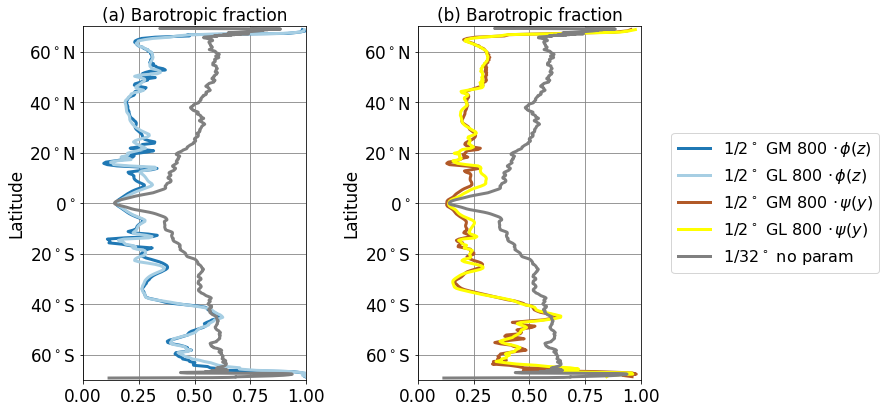

In [15]:
degree = 0.5
    
v = exps_param['nw2_0.5deg_N15_KHGL800_vary_hbbl5']
v['label'] = r'1/2$^\circ$ GL 800 $\cdot\, \psi(y)$'
v = exps_param['nw2_0.5deg_N15_KHTH800_vary']
v['label'] = r'1/2$^\circ$ GM 800 $\cdot\, \psi(y)$'
v = exps_param['nw2_0.5deg_N15_EBT_KHGL800_hbbl5']
v['label'] = r'1/2$^\circ$ GL 800 $\cdot\, \phi(z)$'
v = exps_param['nw2_0.5deg_N15_EBT_KHTH800']
v['label'] = r'1/2$^\circ$ GM 800 $\cdot\, \phi(z)$'

vlist0 = [
    exps_param['nw2_0.5deg_N15_EBT_KHTH800'],
    exps_param['nw2_0.5deg_N15_EBT_KHGL800_hbbl5'],
    exps_unparam['nw2_0.03125deg_N15_baseline_hmix20']
]

vlist1 = [
    exps_param['nw2_0.5deg_N15_KHTH800_vary'],
    exps_param['nw2_0.5deg_N15_KHGL800_vary_hbbl5'],
    exps_unparam['nw2_0.03125deg_N15_baseline_hmix20']
]


colorlist0 = ['#1f78b4', '#a6cee3']
colorlist1 = ['#b15928','yellow']

abc0 = '(a)'
abc1 = '(b)'

fig = BTBC_line(vlist0, vlist1, colorlist0, colorlist1, abc0, abc1, degree)
figname = '/glade/u/home/noraloose/GL90paper/figures/BTBC_0.5degree_appendix.png'
plt.savefig(figname, dpi=200, bbox_inches='tight', pad_inches=0)

### 1/4 degree main text

In [16]:
vlist = [
    exps_param['nw2_0.25deg_N15_KHTH300'],
    exps_param['nw2_0.25deg_N15_KHGL300_hbbl5'],
    exps_param['nw2_0.25deg_N15_KHTH800'],
    exps_param['nw2_0.25deg_N15_KHGL800_hbbl5'],
    exps_unparam['nw2_0.25deg_N15_baseline_hmix20']
]
for v in vlist:
    with ProgressBar():
        v['dst']['baro_fraction'].load()

[########################################] | 100% Completed |  3min 13.9s
[########################################] | 100% Completed |  3min 32.8s
[########################################] | 100% Completed |  3min 16.0s
[########################################] | 100% Completed |  2min 50.0s
[########################################] | 100% Completed |  0.1s


$1/4^\circ$ GM 300: 400; 75002.5
$1/4^\circ$ GL 300: 400; 75002.5
$1/4^\circ$ no param: 400; 30002.5
$1/4^\circ$ GM 800: 400; 75002.5
$1/4^\circ$ GL 800: 400; 75002.5
$1/4^\circ$ no param: 400; 30002.5


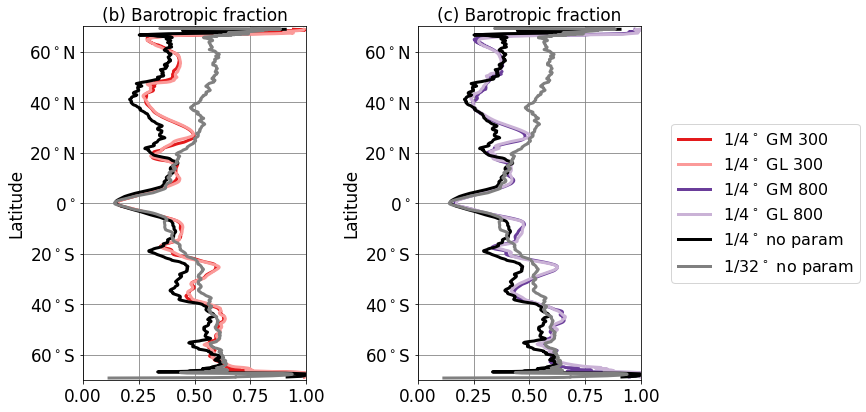

In [17]:
degree = 0.25
    
v = exps_param['nw2_0.25deg_N15_KHGL300_hbbl5']
v['label'] = r'$1/4^\circ$ GL 300'
v = exps_param['nw2_0.25deg_N15_KHGL800_hbbl5']
v['label'] = r'$1/4^\circ$ GL 800'
v = exps_param['nw2_0.25deg_N15_KHTH300']
v['label'] = r'$1/4^\circ$ GM 300'
v = exps_param['nw2_0.25deg_N15_KHTH800']
v['label'] = r'$1/4^\circ$ GM 800'
v = exps_unparam['nw2_0.25deg_N15_baseline_hmix20']
v['label'] = '$1/4^\circ$ no param'


colorlist0 = ['#e31a1c', '#fb9a99', 'k']
colorlist1 = ['#6a3d9a','#cab2d6', 'k']

vlist0 = [
    exps_param['nw2_0.25deg_N15_KHTH300'],
    exps_param['nw2_0.25deg_N15_KHGL300_hbbl5'],
    exps_unparam['nw2_0.25deg_N15_baseline_hmix20']
]
vlist1 = [
    exps_param['nw2_0.25deg_N15_KHTH800'],
    exps_param['nw2_0.25deg_N15_KHGL800_hbbl5'],
    exps_unparam['nw2_0.25deg_N15_baseline_hmix20']
]
abc0 = '(b)'
abc1 = '(c)'

fig = BTBC_line(vlist0, vlist1, colorlist0, colorlist1, abc0, abc1, degree)

figname = '/glade/u/home/noraloose/GL90paper/figures/BTBC_0.25degree.png'
plt.savefig(figname, dpi=200, bbox_inches='tight', pad_inches=0)

### 1/4 degree appendix

In [18]:
vlist = [
    exps_param['nw2_0.25deg_N15_EBT_KHTH300'],
    exps_param['nw2_0.25deg_N15_EBT_KHGL300_hbbl5'],
    exps_param['nw2_0.25deg_N15_KHTH300_vary'],
    exps_param['nw2_0.25deg_N15_KHGL300_vary_hbbl5'],
]
for v in vlist:
    with ProgressBar():
        v['dst']['baro_fraction'].load()

[########################################] | 100% Completed |  2min 54.6s
[########################################] | 100% Completed |  2min 50.4s
[########################################] | 100% Completed |  3min  2.5s
[########################################] | 100% Completed |  3min  6.6s


1/4$^\circ$ GM 300 $\cdot\, \phi(z)$: 400; 75002.5
1/4$^\circ$ GL 300 $\cdot\, \phi(z)$: 400; 75002.5
$1/4^\circ$ no param: 400; 30002.5
1/4$^\circ$ GM 300 $\cdot\, \psi(y)$: 400; 75002.5
1/4$^\circ$ GL 300 $\cdot\, \psi(y)$: 400; 75002.5
$1/4^\circ$ no param: 400; 30002.5


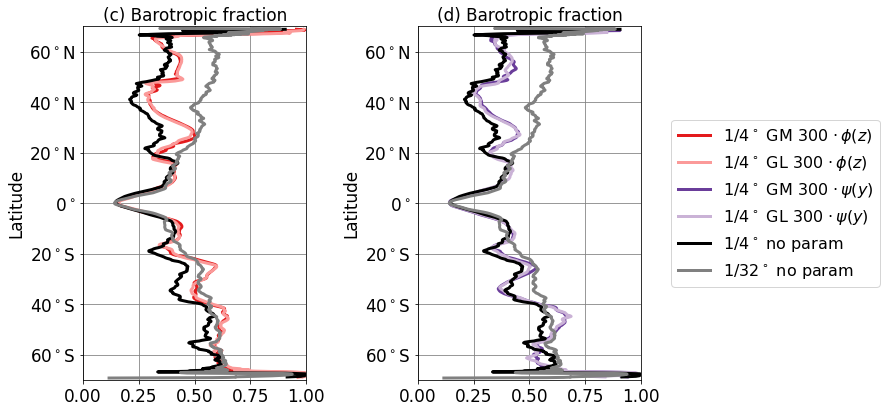

In [20]:
degree = 0.25

v = exps_param['nw2_0.25deg_N15_EBT_KHGL300_hbbl5']
v['label'] = r'1/4$^\circ$ GL 300 $\cdot\, \phi(z)$'
v = exps_param['nw2_0.25deg_N15_EBT_KHTH300']
v['label'] = r'1/4$^\circ$ GM 300 $\cdot\, \phi(z)$'
v = exps_param['nw2_0.25deg_N15_KHGL300_vary_hbbl5']
v['label'] = r'1/4$^\circ$ GL 300 $\cdot\, \psi(y)$'
v = exps_param['nw2_0.25deg_N15_KHTH300_vary']
v['label'] = r'1/4$^\circ$ GM 300 $\cdot\, \psi(y)$'

colorlist0 = ['#e31a1c', '#fb9a99', 'k']
colorlist1 = ['#6a3d9a','#cab2d6', 'k']

vlist0 = [
    exps_param['nw2_0.25deg_N15_EBT_KHTH300'],
    exps_param['nw2_0.25deg_N15_EBT_KHGL300_hbbl5'],
    exps_unparam['nw2_0.25deg_N15_baseline_hmix20']
]

vlist1 = [
    exps_param['nw2_0.25deg_N15_KHTH300_vary'],
    exps_param['nw2_0.25deg_N15_KHGL300_vary_hbbl5'],
    exps_unparam['nw2_0.25deg_N15_baseline_hmix20']
]

abc0 = '(c)'
abc1 = '(d)'

fig = BTBC_line(vlist0, vlist1, colorlist0, colorlist1, abc0, abc1, degree)

figname = '/glade/u/home/noraloose/GL90paper/figures/BTBC_0.25degree_appendix.png'
plt.savefig(figname, dpi=200, bbox_inches='tight', pad_inches=0)

### 1/8 degree

In [21]:
vlist = [
    exps_param['nw2_0.125deg_N15_KHTH100'],
    exps_param['nw2_0.125deg_N15_KHTH800'],
    exps_param['nw2_0.125deg_N15_KHGL100_hbbl5'],
    exps_param['nw2_0.125deg_N15_KHGL800_hbbl5'],
    exps_unparam['nw2_0.125deg_N15_baseline_hmix20']
]
for v in vlist:
    with ProgressBar():
        v['dst']['baro_fraction'].load()

[########################################] | 100% Completed |  8min 11.5s
[########################################] | 100% Completed |  6min 40.1s
[########################################] | 100% Completed |  6min 10.1s
[########################################] | 100% Completed |  6min 17.1s
[########################################] | 100% Completed |  0.1s


1/8$^\circ$ GM 100: 400; 26002.5
1/8$^\circ$ GL 100: 400; 26002.5
1/8$^\circ$ no param: 400; 4002.5
1/8$^\circ$ GM 800: 400; 26002.5
1/8$^\circ$ GL 800: 400; 26002.5
1/8$^\circ$ no param: 400; 4002.5


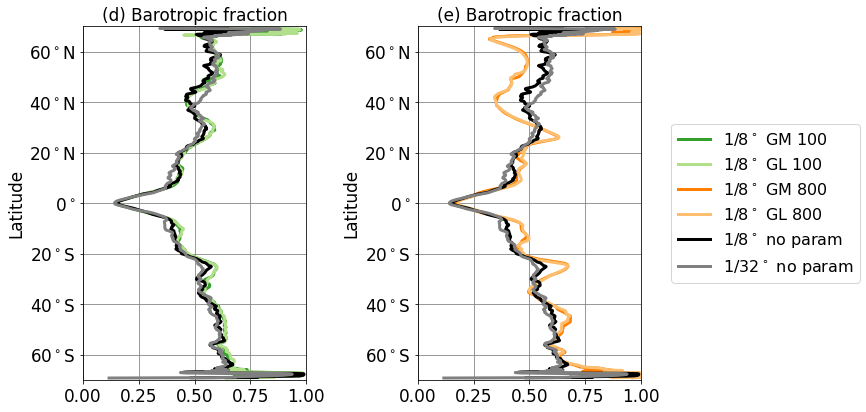

In [22]:
degree = 0.125
    
v = exps_param['nw2_0.125deg_N15_KHGL100_hbbl5']
v['label'] = r'1/8$^\circ$ GL 100'
v = exps_param['nw2_0.125deg_N15_KHGL800_hbbl5']
v['label'] = r'1/8$^\circ$ GL 800'
v = exps_param['nw2_0.125deg_N15_KHTH100']
v['label'] = r'1/8$^\circ$ GM 100'
v = exps_param['nw2_0.125deg_N15_KHTH800']
v['label'] = r'1/8$^\circ$ GM 800'
v = exps_unparam['nw2_0.125deg_N15_baseline_hmix20']
v['label'] = '1/8$^\circ$ no param'


vlist0 = [
    exps_param['nw2_0.125deg_N15_KHTH100'],
    exps_param['nw2_0.125deg_N15_KHGL100_hbbl5'],
    exps_unparam['nw2_0.125deg_N15_baseline_hmix20']
]
vlist1 = [
    exps_param['nw2_0.125deg_N15_KHTH800'],
    exps_param['nw2_0.125deg_N15_KHGL800_hbbl5'],
    exps_unparam['nw2_0.125deg_N15_baseline_hmix20']
]

colorlist0 = ['#33a02c', '#b2df8a', 'k']
colorlist1 = [ '#ff7f00',  '#fdbf6f', 'k']

abc0 = '(d)'
abc1 = '(e)'

fig = BTBC_line(vlist0, vlist1, colorlist0, colorlist1, abc0, abc1, degree)

figname = '/glade/u/home/noraloose/GL90paper/figures/BTBC_0.125degree.png'
plt.savefig(figname, dpi=200, bbox_inches='tight', pad_inches=0)

### 1/8 degree appendix

In [24]:
vlist = [
    exps_param['nw2_0.125deg_N15_KHTH100_vary'],
    exps_param['nw2_0.125deg_N15_EBT_KHTH100'],
    exps_param['nw2_0.125deg_N15_KHGL100_vary_hbbl5'],
    exps_param['nw2_0.125deg_N15_EBT_KHGL100_hbbl5']
]
for v in vlist:
    with ProgressBar():
        v['dst']['baro_fraction'].load()

[########################################] | 100% Completed |  6min 22.7s
[########################################] | 100% Completed |  6min 12.3s
[########################################] | 100% Completed |  6min 15.0s


1/8$^\circ$ GM 100 $\cdot\, \phi(z)$: 400; 26002.5
1/8$^\circ$ GL 100 $\cdot\, \phi(z)$: 400; 26002.5
1/8$^\circ$ no param: 400; 4002.5
1/8$^\circ$ GM 100 $\cdot\, \psi(y)$: 400; 26002.5
1/8$^\circ$ GL 100 $\cdot\, \psi(y)$: 400; 26002.5
1/8$^\circ$ no param: 400; 4002.5


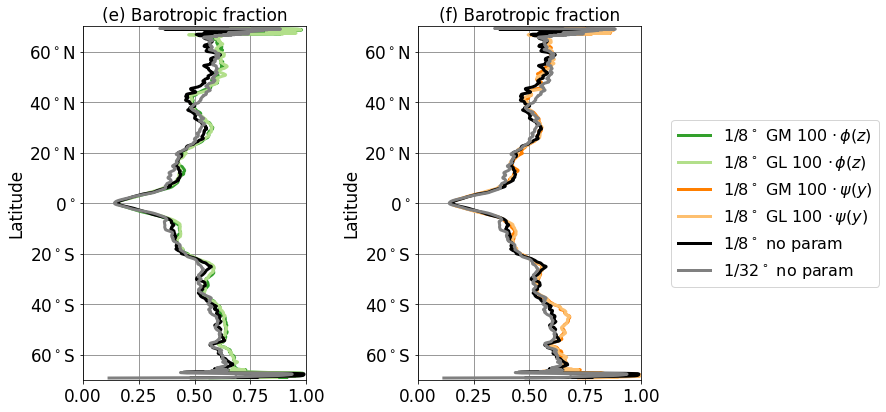

In [25]:
degree = 0.125
    
v = exps_param['nw2_0.125deg_N15_EBT_KHGL100_hbbl5']
v['label'] = r'1/8$^\circ$ GL 100 $\cdot\, \phi(z)$'
v = exps_param['nw2_0.125deg_N15_KHGL100_vary_hbbl5']
v['label'] = r'1/8$^\circ$ GL 100 $\cdot\, \psi(y)$'
v = exps_param['nw2_0.125deg_N15_EBT_KHTH100']
v['label'] = r'1/8$^\circ$ GM 100 $\cdot\, \phi(z)$'
v = exps_param['nw2_0.125deg_N15_KHTH100_vary']
v['label'] = r'1/8$^\circ$ GM 100 $\cdot\, \psi(y)$'

colorlist0 = ['#33a02c', '#b2df8a', 'k']
colorlist1 = [ '#ff7f00',  '#fdbf6f', 'k']

vlist0 = [
    exps_param['nw2_0.125deg_N15_EBT_KHTH100'],
    exps_param['nw2_0.125deg_N15_EBT_KHGL100_hbbl5'],
    exps_unparam['nw2_0.125deg_N15_baseline_hmix20']
]

vlist1 = [
    exps_param['nw2_0.125deg_N15_KHTH100_vary'],
    exps_param['nw2_0.125deg_N15_KHGL100_vary_hbbl5'],
    exps_unparam['nw2_0.125deg_N15_baseline_hmix20']
]

abc0 = '(e)'
abc1 = '(f)'

fig = BTBC_line(vlist0, vlist1, colorlist0, colorlist1, abc0, abc1, degree)
figname = '/glade/u/home/noraloose/GL90paper/figures/BTBC_0.125degree_appendix.png'
plt.savefig(figname, dpi=200, bbox_inches='tight', pad_inches=0)